In [10]:
# ===============================
# Import Libraries
# ===============================
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [11]:
# ===============================
# Load Dataset
# ===============================
df = pd.read_csv("/content/3) Sentiment dataset.csv").dropna()

# ===============================
# Auto Map to Positive / Negative / Neutral
# ===============================
def map_sentiment_auto(label):
    label = str(label).lower()
    positive_keywords = ['joy', 'excite', 'happy', 'delight', 'content', 'love', 'satisf', 'cheer', 'bliss', 'thrill', 'magic']
    negative_keywords = ['sad', 'anger', 'frustrat', 'disappoint', 'lonely', 'stress', 'fear', 'gloom', 'depress', 'hate']

    if any(word in label for word in positive_keywords):
        return "Positive"
    elif any(word in label for word in negative_keywords):
        return "Negative"
    else:
        return "Neutral"

df['label'] = df['Sentiment'].apply(map_sentiment_auto)
print("After Mapping:\n", df['label'].value_counts())

After Mapping:
 label
Neutral     559
Positive    134
Negative     39
Name: count, dtype: int64


In [12]:
# ===============================
# Text Vectorization
# ===============================
X = df['Text']
y = df['label']

vectorizer = TfidfVectorizer(max_features=8000, stop_words='english')
X_vectorized = vectorizer.fit_transform(X)


In [13]:
# ===============================
# SMOTE Oversampling
# ===============================
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_vectorized, y)
print("\nAfter SMOTE:", pd.Series(y_resampled).value_counts())



After SMOTE: label
Neutral     559
Negative    559
Positive    559
Name: count, dtype: int64


In [14]:
# ===============================
# Train-Test Split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# ===============================
# Train Random Forest with Class Weights
# ===============================
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

params = {
    'n_estimators': [200, 300],
    'max_depth': [None, 20],
    'max_features': ['sqrt'],
    'class_weight': ['balanced']
}

grid = GridSearchCV(rf, params, cv=3, scoring='f1_macro', verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
print("\nBest Parameters:", grid.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 300}


In [15]:
# ===============================
# Cross-Validation Evaluation
# ===============================
print("\nCross-Validation Scores (F1 Macro):")
cv_scores = cross_val_score(best_rf, X_resampled, y_resampled, cv=5, scoring='f1_macro')
print("Scores:", cv_scores)
print("Mean F1:", np.mean(cv_scores))


Cross-Validation Scores (F1 Macro):
Scores: [0.90257131 0.97320093 0.97598361 0.98809144 0.93597545]
Mean F1: 0.9551645494523715


In [16]:
# ===============================
# Final Evaluation on Test Set
# ===============================
y_pred = best_rf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.98      0.99       112
     Neutral       0.92      0.98      0.95       112
    Positive       0.98      0.94      0.96       112

    accuracy                           0.97       336
   macro avg       0.97      0.97      0.97       336
weighted avg       0.97      0.97      0.97       336



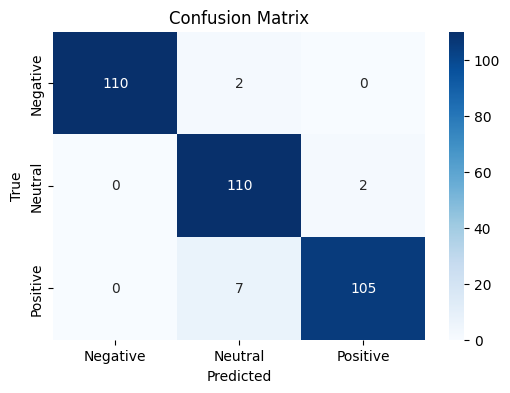

In [17]:
# ===============================
# Confusion Matrix
# ===============================
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative','Neutral','Positive'], yticklabels=['Negative','Neutral','Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Top 20 Important Words:
contentment: 0.0166
excitement: 0.0163
disappointment: 0.0143
fear: 0.0140
joy: 0.0132
laughter: 0.0124
night: 0.0107
frustration: 0.0103
sadness: 0.0101
feeling: 0.0098
unknown: 0.0097
online: 0.0094
keeping: 0.0094
dealing: 0.0094
circumstances: 0.0092
school: 0.0087
disappointed: 0.0086
comments: 0.0084
personal: 0.0080
unexpected: 0.0078


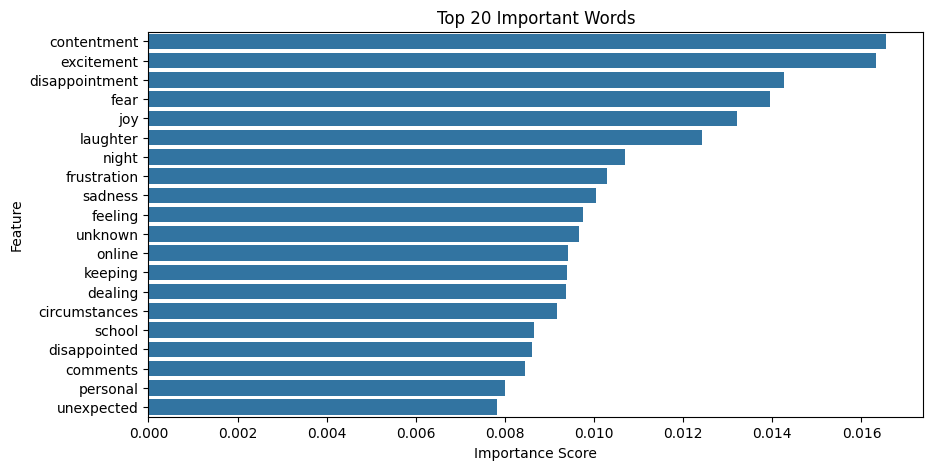

In [18]:
# ===============================
# Feature Importance Analysis
# ===============================
importances = best_rf.feature_importances_
feature_names = vectorizer.get_feature_names_out()

# Get top 20 important words
important_features = sorted(zip(importances, feature_names), reverse=True)[:20]
print("\nTop 20 Important Words:")
for score, word in important_features:
    print(f"{word}: {score:.4f}")

# Plot Feature Importance
scores, words = zip(*important_features)
plt.figure(figsize=(10,5))
sns.barplot(x=scores, y=words)
plt.title("Top 20 Important Words")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()